In [1]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from hipt_4k import HIPT_4K
from hipt_heatmap_utils import *
from hipt_model_utils import eval_transforms as imported_eval_transforms
from scipy.spatial.distance import pdist, squareform
from skimage import io, util
from torchvision import transforms
from tqdm import tqdm


def process_image(image_path):
    """Reads and processes the image based on its dimensions."""
    img = io.imread(image_path)
    if img is None:
        return "Invalid image path"

    h, w, _ = img.shape
    pad_h, pad_w = 4096 - h, 4096 - w
    coordinates = []

    if h < 4096 or w < 4096:
        padding = (
            (0, pad_h),
            (0, pad_w),
            (0, 0),
        )  # Define padding in the format ((top, bottom), (left, right), (0, 0))
        padded_img = np.pad(img, padding, mode="reflect")
        return np.expand_dims(padded_img, axis=0), [[0, 0]]

    else:
        patches = []
        for i in range(0, h, 4096):
            for j in range(0, w, 4096):
                if i + 4096 <= h and j + 4096 <= w:
                    patch = img[i : i + 4096, j : j + 4096]
                    patches.append(patch)
                    coordinates.append([i, j])

        return np.array(patches), coordinates


def evaluate_patches(patches, model):
    """Evaluates a list of patches and returns the outputs."""
    outputs = []
    transform = imported_eval_transforms()  # Initialize once if it's an object

    for patch in tqdm(patches):
        transformed_patch = transform(patch)  # Use as an object

        # Convert to PyTorch tensor and adjust dimensions
        transformed_patch_tensor = (
            torch.tensor(transformed_patch).unsqueeze(dim=0).float()
        )

        with torch.no_grad():
            output = model(transformed_patch_tensor)
        outputs.append(output.cpu().numpy())

    return outputs


def load_models(device):
    """Loads pretrained models and sets them to evaluation mode."""
    pretrained_weights256 = (
        "/home/siddhesh/Work/Projects/HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth"
    )
    pretrained_weights4k = (
        "/home/siddhesh/Work/Projects/HIPT/HIPT_4K/Checkpoints/vit4k_xs_dino.pth"
    )

    model = HIPT_4K(pretrained_weights256, pretrained_weights4k, device, device)
    model.eval()

    return model


def process_single_image(input_path, output_path):
    # Get list of all image paths in the input folder
    image_path = os.path.join(input_path)

    # Load models once, outside the loop, to avoid redundant loading
    device = torch.device("cuda:0")
    model = load_models(device)

    # Create output file path
    output_file_name = os.path.basename(image_path).replace(".png", "_output.npy")
    output_file_path = os.path.join(output_path, output_file_name)

    # Process each image
    patches, coordinates = process_image(image_path)

    print(f"Number of patches: {len(patches)}")
    
    # Save all patches as images with the correspoding coordinates in the filename in the output folder
    for i, (patch, coord) in enumerate(zip(patches, coordinates)):
        patch_name = os.path.basename(image_path).replace(".png", f"_patch_{i}_x{coord[0]}_y{coord[1]}.png")
        patch_path = os.path.join(output_path, patch_name)
        io.imsave(patch_path, patch)

    # Evaluate patches
    outputs_4k_patch_size = evaluate_patches(patches, model)

    # Save output 
    np.save(output_file_path, outputs_4k_patch_size)


In [2]:
# if __name__ == "__main__":
#     input_path = "/media/siddhesh/D1-k/Kaggle-Ovarian/train_images/10077.png"
#     output_path = "/media/siddhesh/D1-k/Kaggle-Ovarian/output_folder_10077/"

#     # Create the output folder if it doesn't exist
#     os.makedirs(output_path, exist_ok=True)

#     process_single_image(input_path=input_path, output_path=output_path)


In [3]:
input_path = "/media/siddhesh/D1-k/Kaggle-Ovarian/train_images/10077.png"
image_path = os.path.join(input_path)

img = io.imread(image_path)

h, w, _ = img.shape
coordinates = []


# Load models once, outside the loop, to avoid redundant loading
device = torch.device("cuda:0")
model = load_models(device)

outputs = []
transform = imported_eval_transforms()  # Initialize once if it's an object


Take key teacher in provided checkpoint dict
Pretrained weights found at /home/siddhesh/Work/Projects/HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
# of Patches: 196
Take key teacher in provided checkpoint dict
Pretrained weights found at /home/siddhesh/Work/Projects/HIPT/HIPT_4K/Checkpoints/vit4k_xs_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


/tmp/ipykernel_8399/2638101260.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(transformed_patch).unsqueeze(dim=0).float()


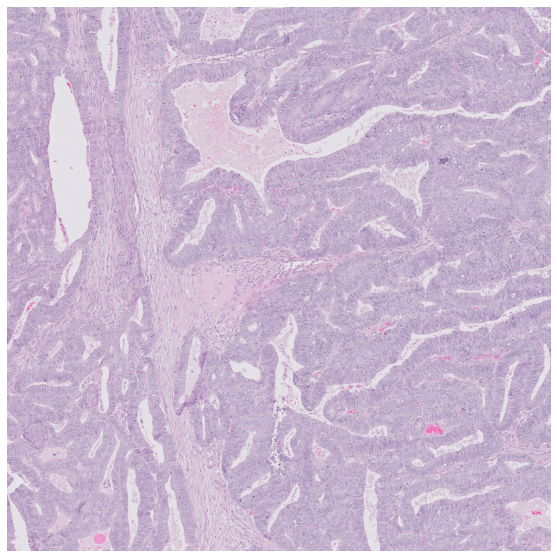

In [4]:
i = 12288
j = 32768

patch_query = img[i : i + 4096, j : j + 4096]

transformed_patch = transform(patch_query)  # Use as an object

# Convert to PyTorch tensor and adjust dimensions
transformed_patch_tensor = (
    torch.tensor(transformed_patch).unsqueeze(dim=0).float()
)

with torch.no_grad():
    output_1 = model(transformed_patch_tensor)

output_1 = output_1.cpu().numpy()

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(patch_query)
plt.axis("off")
plt.show()

In [5]:
sel_i = [12000, 16000]
sel_j = [32000, 36000]

patches = []
outputs = []

for i in sel_i:
    for j in sel_j:

        patch = img[i : i + 4096, j : j + 4096]

        transformed_patch = transform(patch)  # Use as an object

        # Convert to PyTorch tensor and adjust dimensions
        transformed_patch_tensor = (
            torch.tensor(transformed_patch).unsqueeze(dim=0).float()
        )

        with torch.no_grad():
            output_2 = model(transformed_patch_tensor)

        patches.append(patch)
        outputs.append(output_2.cpu().numpy())


/tmp/ipykernel_8399/2007969803.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(transformed_patch).unsqueeze(dim=0).float()


In [ ]:
cosine_similarities, distances = [], []

# Assuming output_1 is a 1D vector, reshape it if needed
output_1 = output_1.reshape(-1)

for output in outputs:
    # Reshape output if needed
    output = output.reshape(-1)
    
    # Calculate cosine similarity
    cosine_similarity = np.dot(output_1, output) / (np.linalg.norm(output_1) * np.linalg.norm(output))
    cosine_similarities.append(cosine_similarity)

    # Calculate Euclidean distance
    distance = np.linalg.norm(output_1 - output)
    distances.append(distance)


In [7]:
import seaborn as sns

# Reshape cosine similarities and distances to a 2x2 grid
cosine_similarities = np.array(cosine_similarities)
distances = np.array(distances)
cosine_similarities = cosine_similarities.reshape(2, 2)
distances = distances.reshape(2, 2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Cosine Similarities
sns.heatmap(cosine_similarities, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, ax=axes[0])
axes[0].set_title("Cosine Similarities")
axes[0].set_xticklabels(["Patch 0", "Patch 1"])
axes[0].set_yticklabels(["Query", "Patch"])
axes[0].set_xlabel("Patches")
axes[0].set_ylabel("")

# Plot Distances
sns.heatmap(distances, annot=True, fmt=".2f", cmap="YlOrRd", cbar=True, ax=axes[1])
axes[1].set_title("Euclidean Distances")
axes[1].set_xticklabels(["Patch 0", "Patch 1"])
axes[1].set_yticklabels(["Query", "Patch"])
axes[1].set_xlabel("Patches")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


NameError: name 'cosine_similarities' is not defined

Cosine Similarities :  [0.9991261, 0.98774534, 0.98597187, 0.9950193]
Euclidean Distances :  [1.3599292, 5.094134, 5.4471483, 3.2463856]


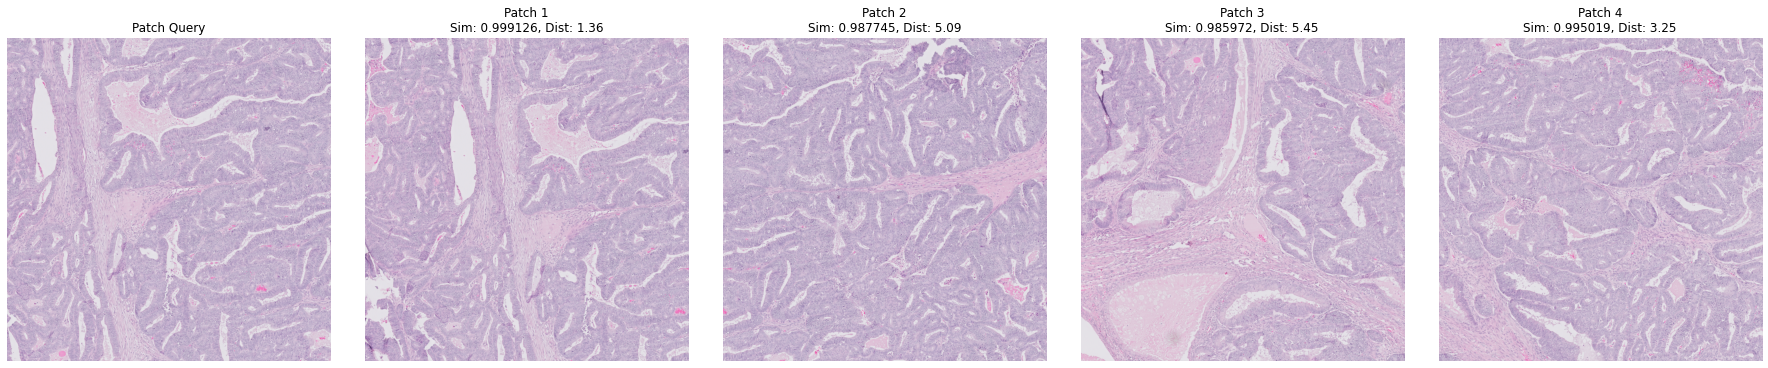

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate cosine similarity
def calculate_cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Function to calculate Euclidean distance
def calculate_euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

# Assuming output_1 and outputs are defined
# Flatten the vectors for similarity and distance calculations
output_1_flat = output_1.reshape(-1)

# Initialize lists to store cosine similarities and distances
cosine_similarities, distances = [], []

# Iterate over each output to calculate cosine similarity and distance
for output in outputs:
    output_flat = output.reshape(-1)
    cosine_similarities.append(calculate_cosine_similarity(output_1_flat, output_flat))
    distances.append(calculate_euclidean_distance(output_1_flat, output_flat))

print("Cosine Similarities : ", cosine_similarities)
print("Euclidean Distances : ", distances)

# Create a single row of subplots with 5 columns (1 for query + 4 for patches)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# List of all patches including the query patch
patches_grid = [patch_query] + patches

# Plot and annotate
for i, ax in enumerate(axes):
    ax.imshow(patches_grid[i])
    ax.axis("off")
    title = f"Patch {i if i != 0 else 'Query'}"
    
    # If it's not the query patch, add similarity and distance info below the image
    if i != 0:
        title += f"\nSim: {cosine_similarities[i-1]:.6f}, Dist: {distances[i-1]:.2f}"
        
    ax.set_title(title)

plt.tight_layout()
plt.show()
